<a href="https://colab.research.google.com/github/glasry/DLcourse2/blob/main/MyFirstLSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt 
from torch.utils.data import DataLoader

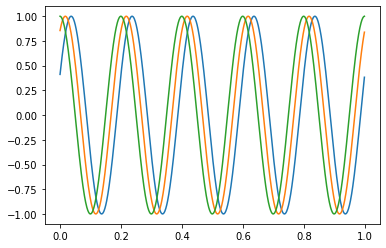

In [24]:
# Generate data
Ndata = 100 # size of data set
f0 = 5
fs = 1000
T  = 1
Nsamples = T * fs
x = np.arange(0, T, 1/fs).reshape(1, Nsamples)
y = np.empty((Ndata, Nsamples)) # initialize 2-D numpy array
vRandomPhase = np.random.uniform(-np.pi, np.pi, Ndata).reshape(Ndata, 1)
y = np.sin(2 * np.pi * f0 * x + vRandomPhase)
plt.figure()
plt.plot(np.transpose(x),y[0,:])
plt.plot(np.transpose(x),y[1,:])
plt.plot(np.transpose(x),y[2,:])
plt.show()

In [25]:
# Define LSTM architecture
class LSTM(nn.Module):
    def __init__(self, hidden_layers=64):
        super(LSTM, self).__init__()
        self.hidden_layers = hidden_layers
        # lstm1, lstm2, linear are all layers in the network
        self.lstm1 = nn.LSTMCell(1, self.hidden_layers)
        self.lstm2 = nn.LSTMCell(self.hidden_layers, self.hidden_layers)
        self.linear = nn.Linear(self.hidden_layers, 1)

    def forward(self, y, future_preds=0):
        outputs, num_samples = [], y.size(0)
        h_t = torch.zeros(num_samples, self.hidden_layers, dtype=torch.float32)
        c_t = torch.zeros(num_samples, self.hidden_layers, dtype=torch.float32)
        h_t2 = torch.zeros(num_samples, self.hidden_layers, dtype=torch.float32)
        c_t2 = torch.zeros(num_samples, self.hidden_layers, dtype=torch.float32)

        for time_step in y.split(1, dim=1):
            # N, 1
            h_t, c_t = self.lstm1(time_step, (h_t, c_t)) # initial hidden and cell states
            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2)) # new hidden and cell states
            output = self.linear(h_t2) # output from the last FC layer
            outputs.append(output)

        for i in range(future_preds):
            # this only generates future predictions if we pass in future_preds>0
            # mirrors the code above, using last output/prediction as input
            h_t, c_t = self.lstm1(output, (h_t, c_t))
            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2))
            output = self.linear(h_t2)
            outputs.append(output)
        
        # transform list to tensor    
        outputs = torch.cat(outputs, dim=1)
        return outputs

In [26]:
# Prepare train and test datasets
# X will be the first Nsamples-1 and y will be the last Nsamples-1.
# Also, we choose the first 97 sinewaves as train and the last 3 as test
X_train = torch.Tensor(y[:97, :-1])
Y_train = torch.Tensor(y[:97, 1:])

X_test = torch.Tensor(y[97:, :-1])
Y_test = torch.Tensor(y[97:, 1:])

print('The training sizes are X,Y ', X_train.shape, Y_train.shape)
print('The test sizes of X,Y are', X_test.shape, Y_test.shape)

The training sizes are X,Y  torch.Size([97, 999]) torch.Size([97, 999])
The test sizes of X,Y are torch.Size([3, 999]) torch.Size([3, 999])


In [41]:
def training_loop(model, X_train, Y_train, X_validation, Y_validation, n_epochs, batch_size):
  
  # Define optimizer and loss function
  loss_fn = nn.MSELoss()
  optimiser = torch.optim.LBFGS(model.parameters(), lr=0.08)
  for iEpoch in range(n_epochs):
    # Shuffle the data
    idcs_shuffled = torch.randperm(X_train.shape[0])
    X_train_shuffle = X_train[idcs_shuffled,:]
    Y_train_shuffle = Y_train[idcs_shuffled,:]
    idx = 0
    while (idx+batch_size) <  X_train.shape[0]:
      print("Epoch: {}, {}%".format(iEpoch, idx/X_train.shape[0]*100))
      X = X_train_shuffle[idx:idx+batch_size,:]
      Y = Y_train_shuffle[idx:idx+batch_size,:]
      def closure():
        optimiser.zero_grad()
        out = model(X)
        # print('Finished epoch ' + str(i))
        loss = loss_fn(out, Y)
        loss.backward()
        return loss
    
      optimiser.step(closure)
      idx += batch_size
    with torch.no_grad():
        future = 1000
        pred = model(X_validation, future_preds=future)
        # print(pred)
        # use all pred samples, but only go to 999
        loss = loss_fn(pred[:, :-future], Y_validation)
        y = pred.detach().numpy()
    # draw figures
    plt.figure(figsize=(12,6))
    plt.title(f"Step {iEpoch+1}")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    n = X_train.shape[1] # 999
    def draw(yi, colour):
        plt.plot(np.arange(n), yi[:n], colour, linewidth=2.0)
        plt.plot(np.arange(n, n+future), yi[n:], colour+":", linewidth=2.0)
    draw(y[0], 'r')
    draw(y[1], 'b')
    draw(y[2], 'g')
    plt.show()
    # plt.savefig("predict%d.png"%i, dpi=200)
    # plt.close()
    # print the loss
    out = model(X_train)
    loss_print = loss_fn(out, Y_train)
    print("Step: {}, Loss train: {}, Loss val: {}".format(iEpoch, loss_print, loss))

Epoch: 0, 0.0%


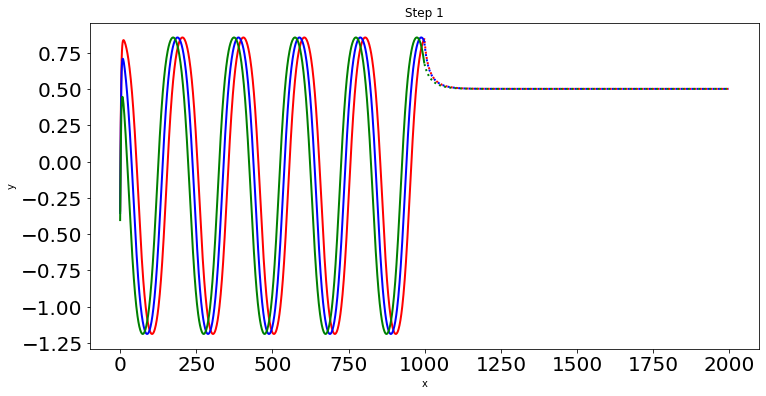

Step: 0, Loss train: 0.028552701696753502, Loss val: 0.030413543805480003
Epoch: 1, 0.0%


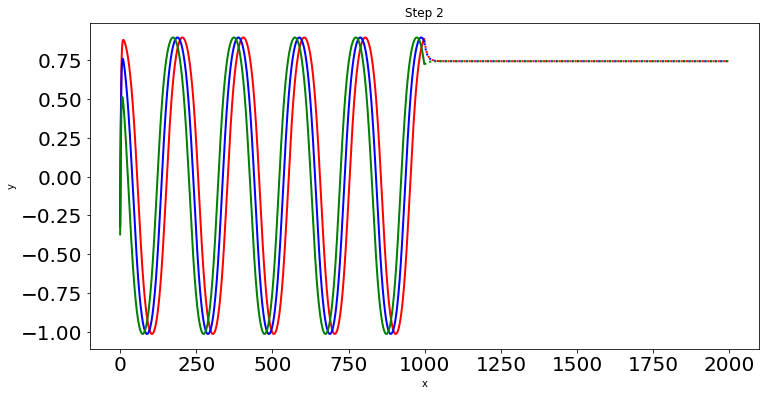

Step: 1, Loss train: 0.010129227302968502, Loss val: 0.011675726622343063
Epoch: 2, 0.0%


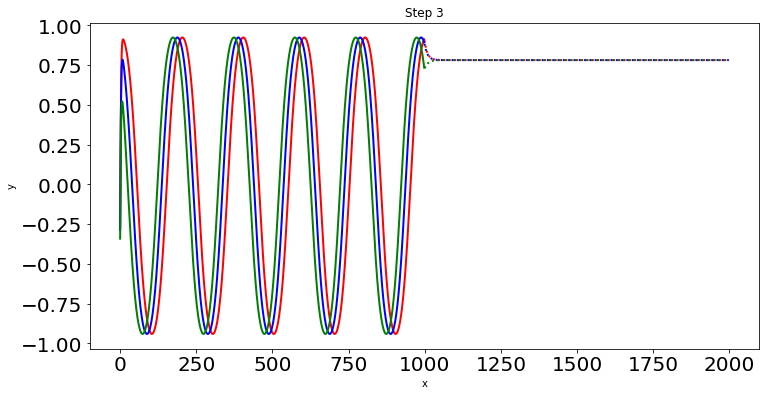

Step: 2, Loss train: 0.007767943199723959, Loss val: 0.009138322435319424
Epoch: 3, 0.0%


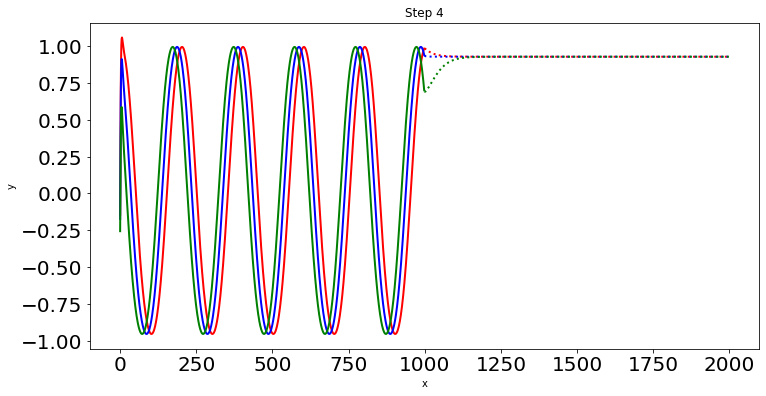

Step: 3, Loss train: 0.002643194980919361, Loss val: 0.003536906326189637
Epoch: 4, 0.0%


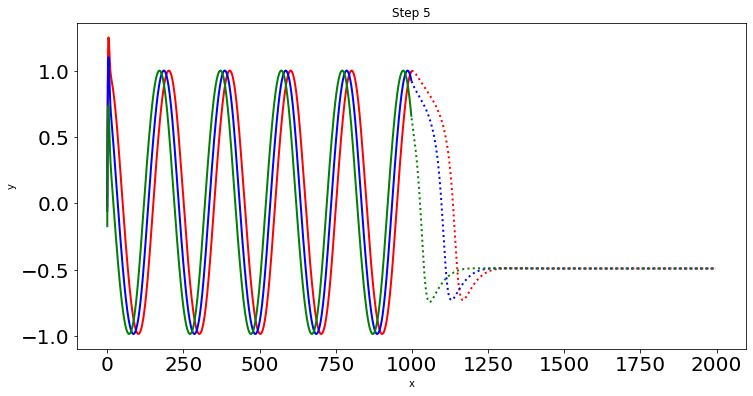

Step: 4, Loss train: 0.0006664916290901601, Loss val: 0.0013507333351299167
Epoch: 5, 0.0%


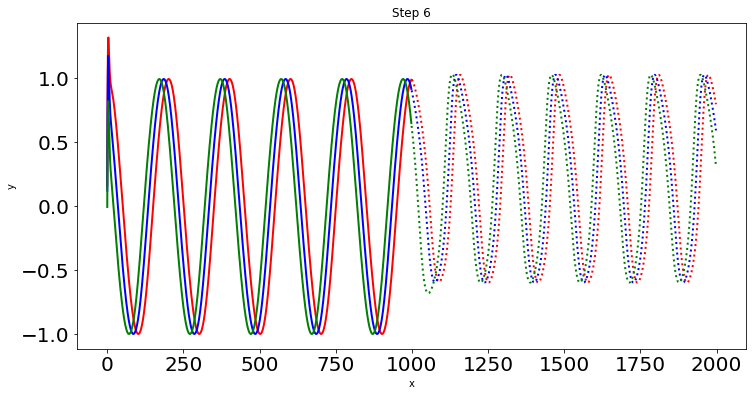

Step: 5, Loss train: 0.00044252010411582887, Loss val: 0.001000112621113658
Epoch: 6, 0.0%


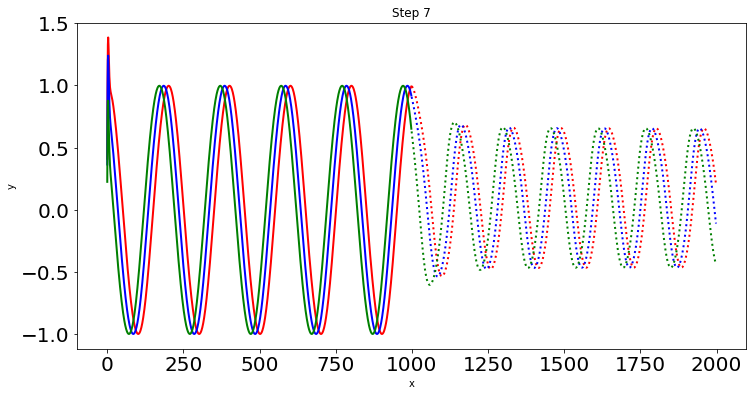

Step: 6, Loss train: 0.00031922030029818416, Loss val: 0.0007333752582781017
Epoch: 7, 0.0%


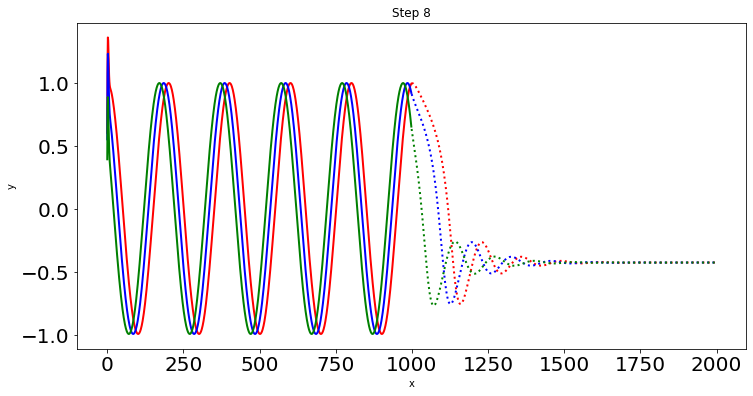

Step: 7, Loss train: 0.00025079547776840627, Loss val: 0.0004895045422017574
Epoch: 8, 0.0%


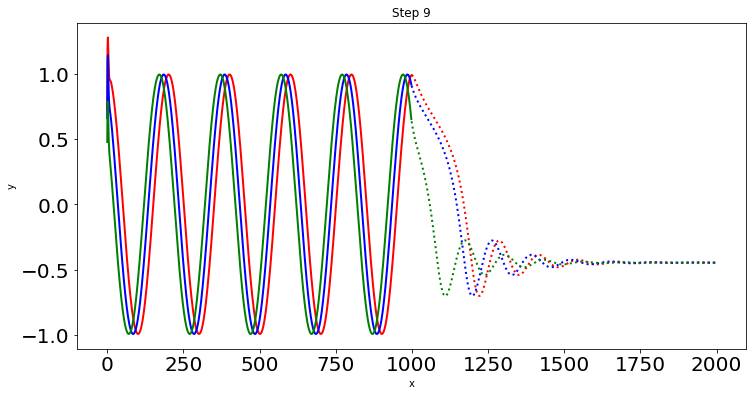

Step: 8, Loss train: 0.00018164317589253187, Loss val: 0.00024017837131395936
Epoch: 9, 0.0%


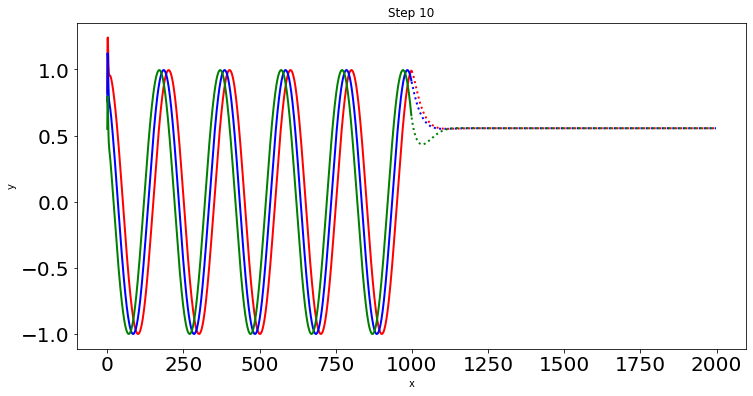

Step: 9, Loss train: 0.0001585339632583782, Loss val: 0.00015702757809776813
Epoch: 10, 0.0%


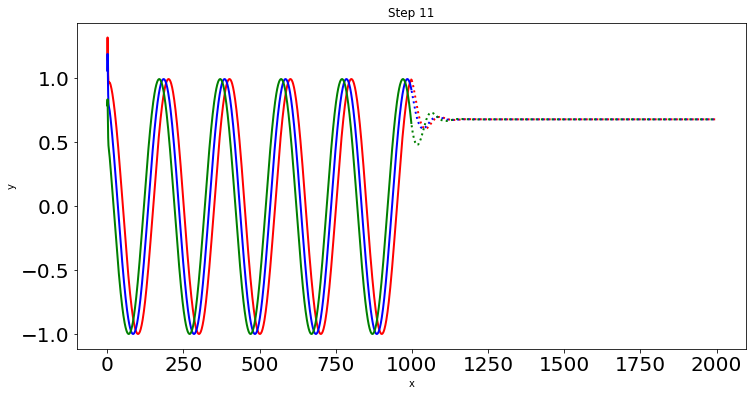

Step: 10, Loss train: 0.00011370691936463118, Loss val: 0.00015405102749355137
Epoch: 11, 0.0%


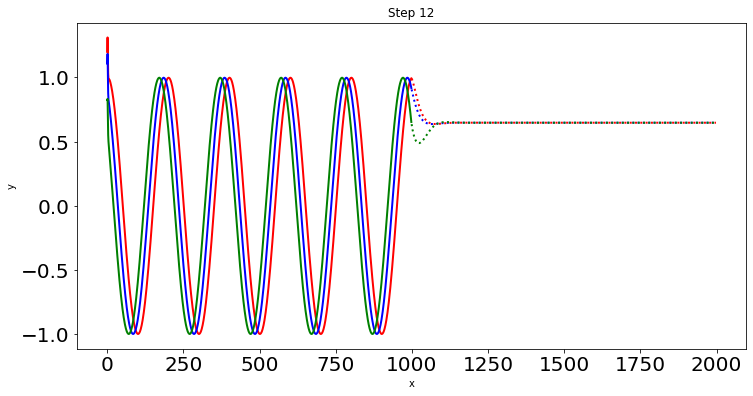

Step: 11, Loss train: 8.37089610286057e-05, Loss val: 0.0001606433215783909
Epoch: 12, 0.0%


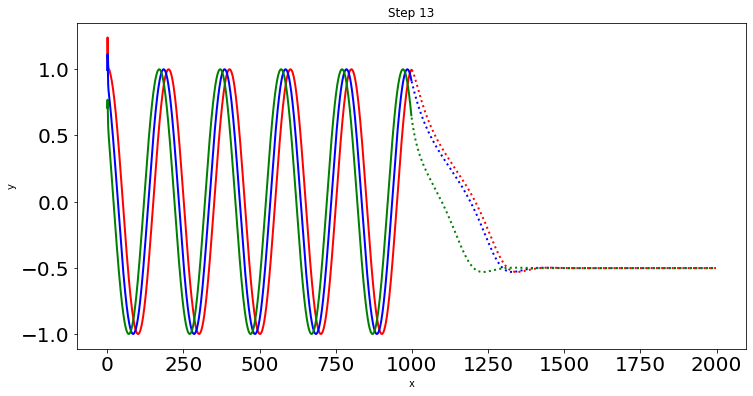

Step: 12, Loss train: 5.88526381761767e-05, Loss val: 8.846067066770047e-05
Epoch: 13, 0.0%


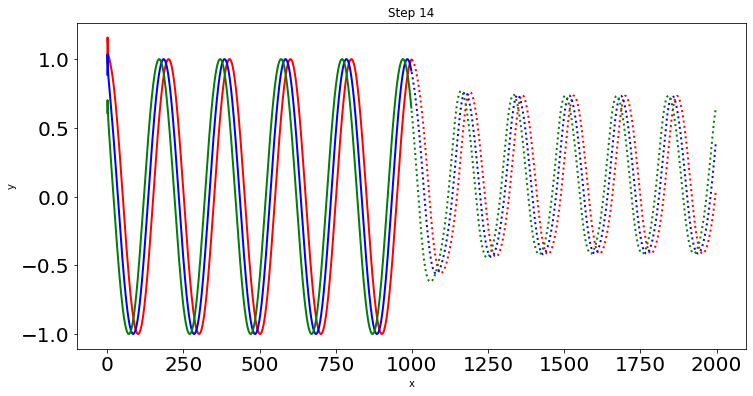

Step: 13, Loss train: 3.650040162028745e-05, Loss val: 4.1613424400566146e-05
Epoch: 14, 0.0%


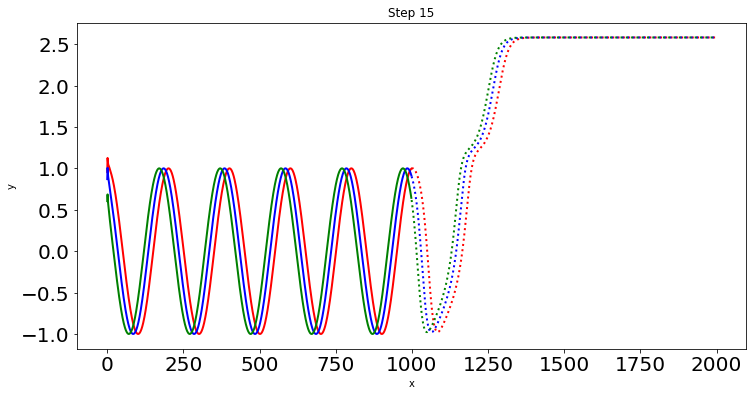

Step: 14, Loss train: 2.2120289941085503e-05, Loss val: 3.895647751051001e-05
Epoch: 15, 0.0%


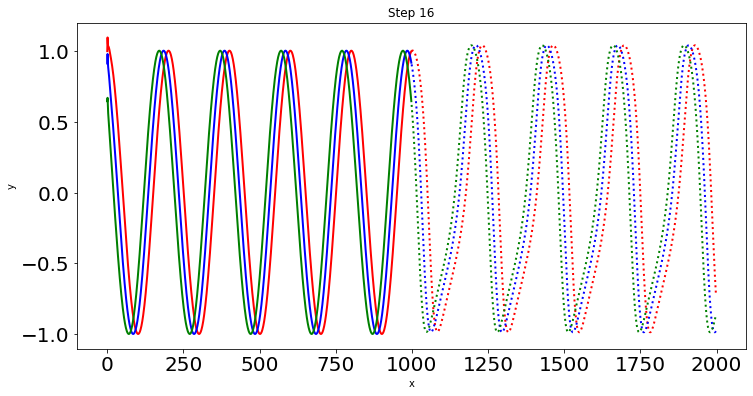

Step: 15, Loss train: 1.572232213220559e-05, Loss val: 2.777886766125448e-05
Epoch: 16, 0.0%


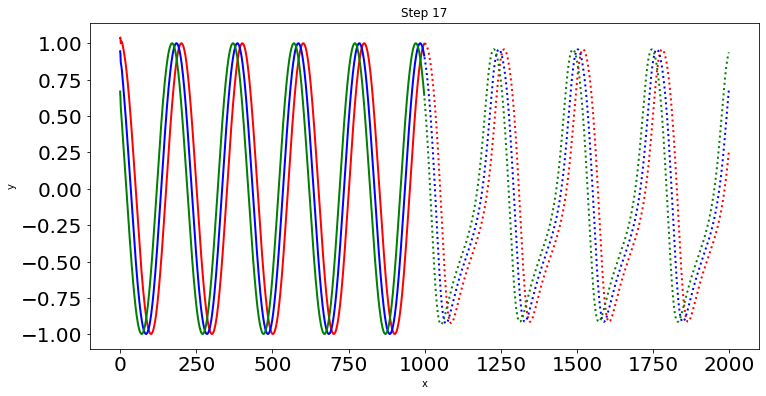

Step: 16, Loss train: 1.058974794432288e-05, Loss val: 1.4769009794690646e-05
Epoch: 17, 0.0%


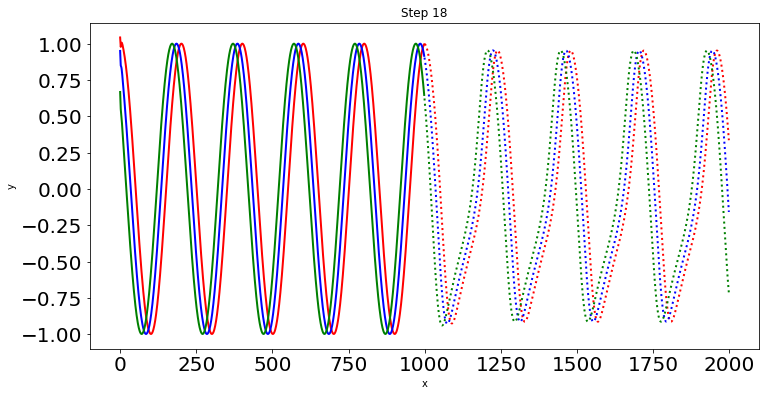

Step: 17, Loss train: 8.554947271477431e-06, Loss val: 1.0579532499832567e-05
Epoch: 18, 0.0%


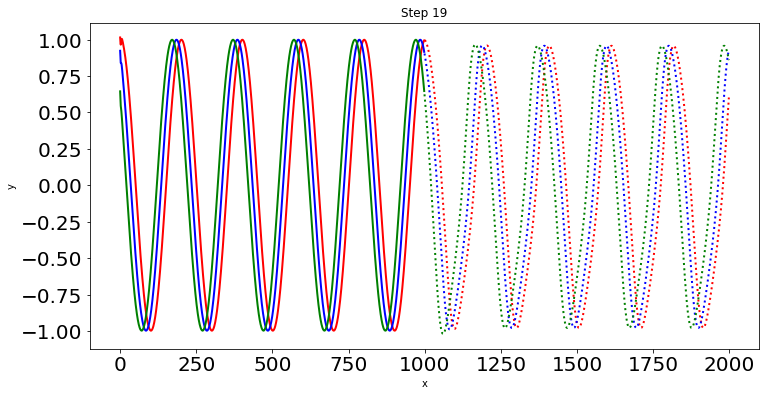

Step: 18, Loss train: 6.131402642495232e-06, Loss val: 6.658616257482208e-06
Epoch: 19, 0.0%


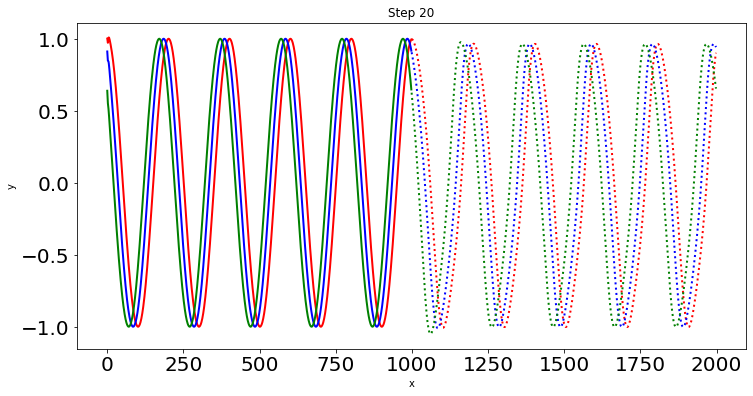

Step: 19, Loss train: 5.363802301872056e-06, Loss val: 6.448585736507084e-06


In [42]:
model = LSTM()
training_loop(model, X_train, Y_train, X_test, Y_test, n_epochs=20, batch_size=95)